# Sentiment Classification with Natural Language Processing on LSTM 

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

In [112]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
df = pd.read_csv('Reviews.csv')

In [114]:
df=df[:10000]

In [115]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [116]:
df.shape

(10000, 10)


# Text Cleaning or Preprocessing

In [117]:
# Cleaning the texts
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, 10000):
    review = re.sub('[^a-zA-Z]', ' ', df['Text'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to C:\Users\Aniruddha
[nltk_data]     choudhury\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [118]:
corpus=pd.DataFrame(corpus, columns=['Reviews']) 
corpus.head()

,Reviews
0,bought sever vital can dog food product found ...
1,product arriv label jumbo salt peanut peanut a...
2,confect around centuri light pillowi citru gel...
3,look secret ingredi robitussin believ found go...
4,great taffi great price wide assort yummi taff...


In [119]:
result=corpus.join(df[['Score']])
result.head()

,Reviews,Score
0,bought sever vital can dog food product found ...,5
1,product arriv label jumbo salt peanut peanut a...,1
2,confect around centuri light pillowi citru gel...,4
3,look secret ingredi robitussin believ found go...,2
4,great taffi great price wide assort yummi taff...,5


# TFIDF

TFIDF is an information retrieval technique that weighs a term’s frequency (TF) and its inverse document frequency (IDF). Each word has its respective TF and IDF score. The product of the TF and IDF scores of a word is called the TFIDF weight of that word.

Put simply, the higher the TFIDF score (weight), the rarer the word and vice versa

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(result['Reviews'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [121]:
X = tfidf.transform(result['Reviews'])
result['Reviews'][1]

'product arriv label jumbo salt peanut peanut actual small size unsalt sure error vendor intend repres product jumbo'

In [122]:
print([X[1, tfidf.vocabulary_['peanut']]])

[0.37509695630835344]


In [123]:
print([X[1, tfidf.vocabulary_['jumbo']]])

[0.5727828521365451]


In [124]:
print([X[1, tfidf.vocabulary_['error']]])

[0.2706003734708304]


Among the three words, “peanut”, “jumbo” and “error”, tf-idf gives the highest weight to “jumbo”. Why? This indicates that “jumbo” is a much rarer word than “peanut” and “error”. This is how to use the tf-idf to indicate the importance of words or terms inside a collection of documents.

# Sentiment Classification

In [125]:
result.dropna(inplace=True)
result[result['Score'] != 3]
result['Positivity'] = np.where(result['Score'] > 3, 1, 0)
cols = [ 'Score']
result.drop(cols, axis=1, inplace=True)
result.head()

,Reviews,Positivity
0,bought sever vital can dog food product found ...,1
1,product arriv label jumbo salt peanut peanut a...,0
2,confect around centuri light pillowi citru gel...,1
3,look secret ingredi robitussin believ found go...,0
4,great taffi great price wide assort yummi taff...,1


In [126]:
result.groupby('Positivity').size()

Positivity
0    2384
1    7616
dtype: int64

# Train Test Split

In [127]:
from sklearn.model_selection import train_test_split
X = result.Reviews
y = result.Positivity
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [128]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train),
                                                                             (len(X_train[y_train == 0]) / (len(X_train)*1.))*100,
                                                                            (len(X_train[y_train == 1]) / (len(X_train)*1.))*100))

Train set has total 7500 entries with 23.57% negative, 76.43% positive


In [129]:
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
                                                                             (len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
                                                                            (len(X_test[y_test == 1]) / (len(X_test)*1.))*100))

Test set has total 2500 entries with 24.64% negative, 75.36% positive


In [130]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [131]:
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

In [150]:
cv = CountVectorizer()
rf = RandomForestClassifier(class_weight="balanced")
n_features = np.arange(10000,25001,5000)

def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result

In [151]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [152]:
print("Result for trigram with stop words (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tfidf,ngram_range=(1, 3))

Result for trigram with stop words (Tfidf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


Test result for 10000 features


E:\PYTHONANACONDA\envs\py37\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy score: 82.52%
Test result for 15000 features
accuracy score: 82.80%
Test result for 20000 features
accuracy score: 82.40%
Test result for 25000 features
accuracy score: 82.24%


In [153]:
from sklearn.metrics import classification_report

cv = CountVectorizer(max_features=30000,ngram_range=(1, 3))
pipeline = Pipeline([
        ('vectorizer', cv),
        ('classifier', rf)
    ])
sentiment_fit = pipeline.fit(X_train, y_train)
y_pred = sentiment_fit.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.74      0.52      0.61       616
    positive       0.86      0.94      0.90      1884

   micro avg       0.84      0.84      0.84      2500
   macro avg       0.80      0.73      0.75      2500
weighted avg       0.83      0.84      0.83      2500



In [154]:
## K-fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = pipeline, X= X_train, y = y_train,
                             cv = 10)
print("Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(), accuracies.std() * 2))

Random Forest Classifier Accuracy: 0.82 (+/- 0.02)


# Chi2 Feature Selection

In [138]:
from sklearn.feature_selection import chi2

tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(result.Reviews)
y = result.Positivity
chi2score = chi2(X_tfidf, y)[0]

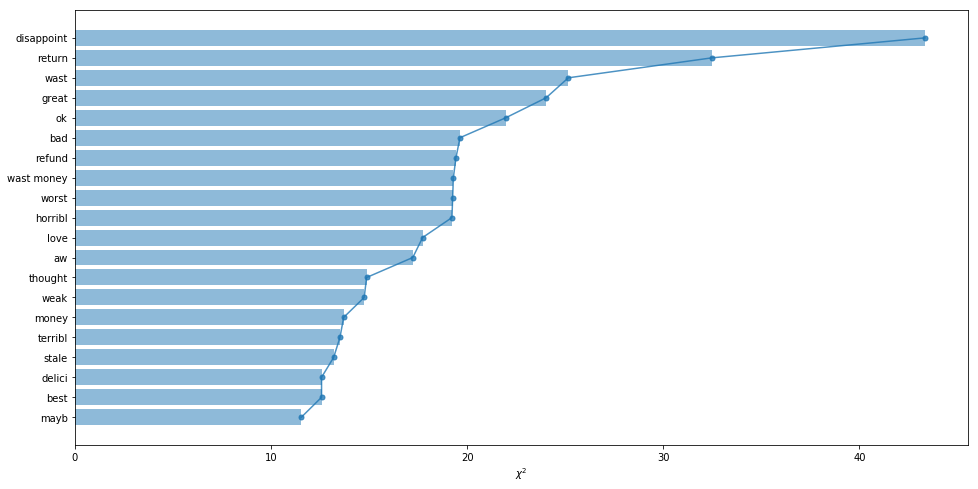

In [140]:
plt.figure(figsize=(16,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

# LSTM neural network

In [155]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [156]:
max_fatures = 30000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(result['Reviews'].values)
X1 = tokenizer.texts_to_sequences(result['Reviews'].values)
X1 = pad_sequences(X1)

E:\PYTHONANACONDA\envs\py37\lib\site-packages\keras_preprocessing\text.py:177: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [157]:
Y1 = pd.get_dummies(result['Positivity']).values
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)

(7500, 932) (7500, 2)
(2500, 932) (2500, 2)


Keras Embedding Layer
Keras offers an Embedding layer that can be used for neural networks on text data.

It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.

The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.

It is a flexible layer that can be used in a variety of ways, such as:

It can be used alone to learn a word embedding that can be saved and used in another model later.
It can be used as part of a deep learning model where the embedding is learned along with the model itself.
It can be used to load a pre-trained word embedding model, a type of transfer learning.
The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

It must specify 3 arguments:

input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.
For example, below we define an Embedding layer with a vocabulary of 200 (e.g. integer encoded words from 0 to 199, inclusive), a vector space of 32 dimensions in which words will be embedded, and input documents that have 50 words each.


e = Embedding(200, 32, input_length=50)
1
e = Embedding(200, 32, input_length=50)
The Embedding layer has weights that are learned. If you save your model to file, this will include weights for the Embedding layer.

The output of the Embedding layer is a 2D vector with one embedding for each word in the input sequence of words (input document).

If you wish to connect a Dense layer directly to an Embedding layer, you must first flatten the 2D output matrix to a 1D vector using the Flatten layer.

In [158]:
embed_dim = 150
lstm_out = 200

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X1.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

E:\PYTHONANACONDA\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """
E:\PYTHONANACONDA\envs\py37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 932, 150)          4500000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               280800    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 4,781,202
Trainable params: 4,781,202
Non-trainable params: 0
_________________________________________________________________
None


Next, I compose the LSTM Network. Note that embed_dim, lstm_out, batch_size, droupout_x variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. Please also note that I am using softmax as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.

In [159]:
batch_size = 32
model.fit(X1_train, Y1_train, nb_epoch = 10, batch_size=batch_size, verbose = 2)

E:\PYTHONANACONDA\envs\py37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/10
 - 1034s - loss: 0.4479 - acc: 0.8013
Epoch 2/10
 - 1083s - loss: 0.2677 - acc: 0.8923
Epoch 3/10
 - 1066s - loss: 0.1802 - acc: 0.9311
Epoch 4/10
 - 1047s - loss: 0.1168 - acc: 0.9596
Epoch 5/10


KeyboardInterrupt: 

In [161]:
score,acc = model.evaluate(X1_test, Y1_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.51
acc: 0.84



Finally measuring the number of correct guesses. It is clear that finding negative tweets goes very well for the Network but deciding whether is positive is not really.

In [163]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X1_test)):
    
    result = model.predict(X1_test[x].reshape(1,X1_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y1_test[x]):
        if np.argmax(Y1_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y1_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 90.67439409905164 %
neg_acc 63.2890365448505 %
